# 5.5 Exponential Families

### Setup

In [1]:
%matplotlib inline

In [2]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

Load data

In [3]:
# dataset is a single column; extract it as a Series
gfr = pd.read_csv("../data/gfr.txt", delimiter=" ", header=None, names=["gfr"])
gfr = gfr.gfr

In [4]:
gfr.head()

0    108
1     91
2     62
3     59
4     84
Name: gfr, dtype: int64

### Figure 5.6

In [5]:
x_vals = np.arange(31)

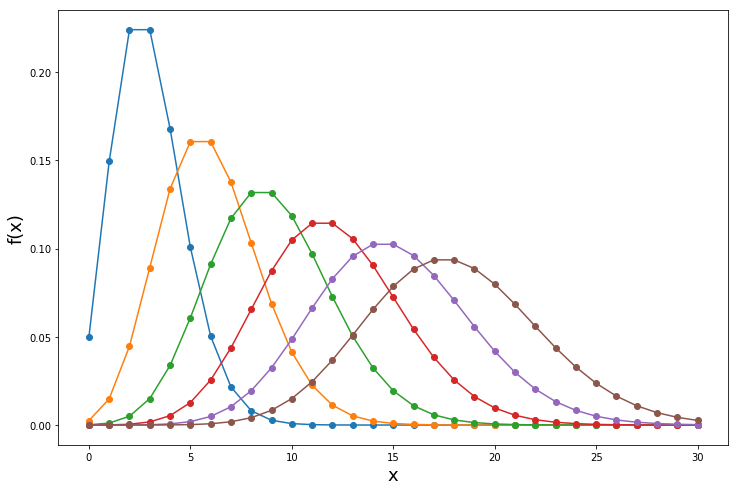

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

for mu in range(3, 21, 3):
    ax.plot(x_vals, stats.poisson(mu).pmf(x_vals), "o-")

ax.set_xlabel("x", size=18)
ax.set_ylabel("f(x)", size=18);

### Figure 5.7

For the gamma curve, we'll use `scipy.stats.gamma`, which has a `fit` method. Pg 171 describes how to fit the Poisson curve, but there's an extra step where the powers of the data are converted to orthogonal polynomials. See notebook [ch10s04.ipynb](../chapter10/ch10s04.ipynb) for a comparison of the results with and without that step.

I'll bin almost the same as described on page 171:

> The x-axis was partitioned into K=32 bins, with endpoints 13, 16, 19, ... 109

That partition didn't given me exactly the same histogram. Instead, I will use endpoints 13.5, 16.5, etc.

In [7]:
frequency, edges = np.histogram(gfr, bins=np.arange(13.5, 112, 3))
hist_area = ((edges[1:] - edges[:-1]) * frequency).sum()

In [8]:
centers = (edges[:-1] + edges[1:]) / 2

Fit the Poisson model

In [9]:
# this makes the orthogonal polynomials
# https://stackoverflow.com/a/41317397

def make_poly(x, degree, orthogonal=False):
    x_mat = np.transpose(np.vstack((x**k for k in range(degree + 1))))
    if orthogonal:
        x_mat = np.linalg.qr(x_mat)[0]
        x_mat[:, 0] = 1
    columns = ["x{}".format(i) for i in range(degree + 1)]
    return pd.DataFrame(x_mat, columns=columns)

In [10]:
poly_X = make_poly(centers, degree=7, orthogonal=True)

In [11]:
model = sm.GLM(
    frequency,
    poly_X,
    family=sm.families.Poisson(),
)
results = model.fit()

Get model predictions to plot the curve across the histogram

In [12]:
y_poisson = results.predict(poly_X)

Fit the gamma distribution and get distribution values

In [13]:
x_vals = np.arange(13, 110)

In [14]:
params = stats.gamma.fit(gfr)
y_gamma = stats.gamma.pdf(x_vals, *params)

Make the plot

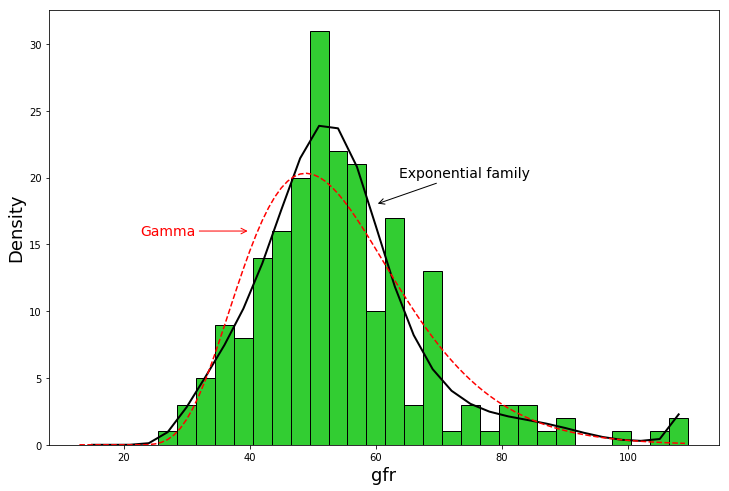

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(
    centers,
    frequency,
    width=np.diff(edges),
    align="center",
    edgecolor="k",
    color="limegreen",
)

ax.plot(centers, y_poisson, c="k", linewidth=2)
ax.annotate(
    "Exponential family",
    size=14,
    xy=(60, 18),
    xytext=(74, 20),
    arrowprops=dict(
        arrowstyle="->",
        facecolor="black",
    ),
    horizontalalignment="center",
)

ax.plot(x_vals, y_gamma * hist_area, linestyle="--", c="r")
ax.annotate(
    "Gamma",
    size=14,
    xy=(40, 16),
    xytext=(27, 16),
    color="red",
    arrowprops=dict(
        arrowstyle="->",
        color="red",
    ),
    verticalalignment="center",
    horizontalalignment="center",
)

ax.set_xlabel("gfr", size=18)
ax.set_ylabel("Density", size=18);